In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('train.csv')

print(df.head())
print(df.info())
print(df.describe(include='all'))

   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   0    Male   21                1         35.0                   0   
1   1    Male   43                1         28.0                   0   
2   2  Female   25                1         14.0                   1   
3   3  Female   35                1          1.0                   0   
4   4  Female   36                1         15.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    1-2 Year            Yes         65101.0                 124.0      187   
1   > 2 Years            Yes         58911.0                  26.0      288   
2    < 1 Year             No         38043.0                 152.0      254   
3    1-2 Year            Yes          2630.0                 156.0       76   
4    1-2 Year             No         31951.0                 152.0      294   

   Response  
0         0  
1         1  
2         0  
3         0  
4         0  
<class '

### Удаление дупликатов и пустых данных

In [ ]:
print("\nПропуски:\n", df.isnull().sum())

print("\nДубликаты:\n", df.duplicated().sum())

df = df.drop_duplicates()

initial_shape = df.shape

# Удаляем строки с хотя бы одним NaN
df = df.dropna()

# Информация о потерях
print(f"\nБыло строк: {initial_shape[0]}")
print(f"Стало строк после удаления NaN: {df.shape[0]}")
print(f"Удалено строк: {initial_shape[0] - df.shape[0]}")

df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_mapping)




Пропуски:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Дубликаты:
 0

Было строк: 11504798
Стало строк после удаления NaN: 11504798
Удалено строк: 0


### Корреляционная матрица

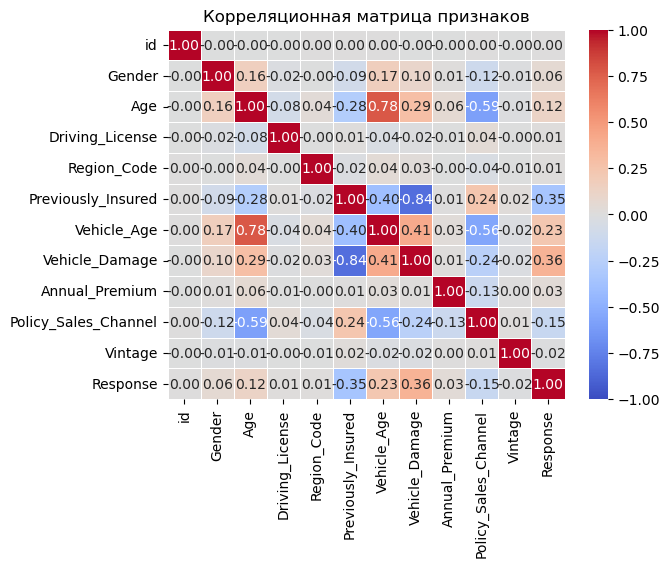

In [3]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1., vmax=1.)
plt.title('Корреляционная матрица признаков')
plt.show()

Следующие переменные:

1. id
2. gender
3. driving_license
4. region_code
5. annual_premium
6. vintage

Точно не имеют никакой связи с response, значит, что от них нужно избавиться в первую очередь

Также можно избавиться от признака ```Age```, так как он сильно коррелирует с ```Vehicle_Age```

### Удаление первостепенных признаков

In [4]:
first_to_drop = ["id", "Gender", "Driving_License", "Region_Code", "Annual_Premium", "Vintage"]
second_to_drop = ["Age"]

df.drop(columns=first_to_drop, inplace=True)
df.drop(columns=second_to_drop, inplace=True)

### Распределение Response

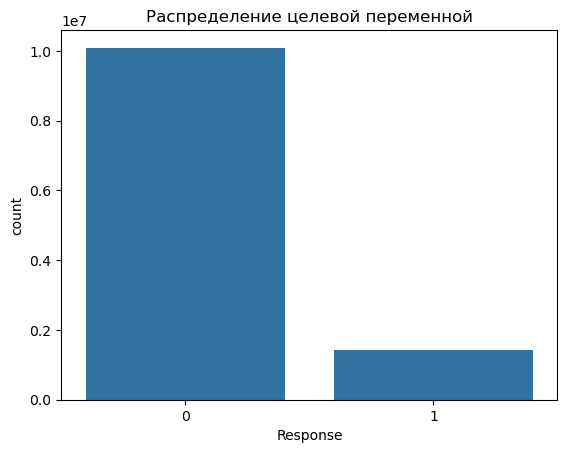

In [5]:
sns.countplot(x='Response', data=df)
plt.title('Распределение целевой переменной')
plt.show()

Данные неравномерно распределены по Response, тогда при делении выборки мы сделаем стратификацию по целевой переменной

In [6]:
print(df.head())
print(df.info())

df.to_csv('train_cleaned.csv', index=False)

print("\nДанные успешно очищены и сохранены в 'train_cleaned.csv'!")

   Previously_Insured  Vehicle_Age  Vehicle_Damage  Policy_Sales_Channel  \
0                   0            1               1                 124.0   
1                   0            2               1                  26.0   
2                   1            0               0                 152.0   
3                   0            1               1                 156.0   
4                   1            1               0                 152.0   

   Response  
0         0  
1         1  
2         0  
3         0  
4         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 5 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Previously_Insured    int64  
 1   Vehicle_Age           int64  
 2   Vehicle_Damage        int64  
 3   Policy_Sales_Channel  float64
 4   Response              int64  
dtypes: float64(1), int64(4)
memory usage: 438.9 MB
None

Данные успешно очищены и сохранены в 'trai

### Проверка на выбросы

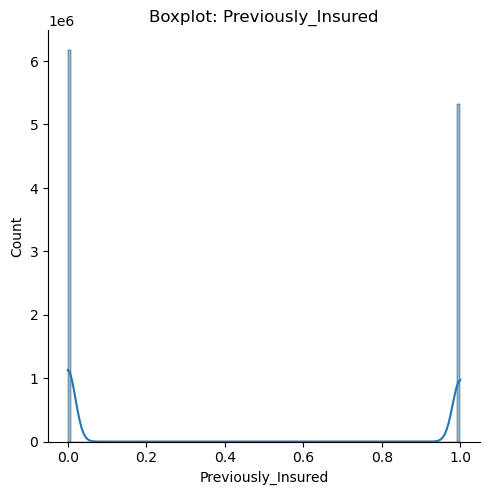

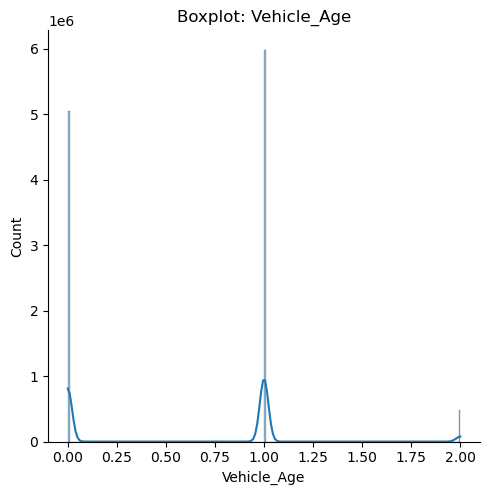

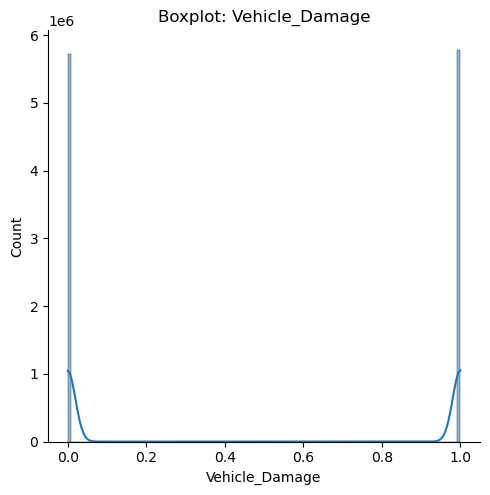

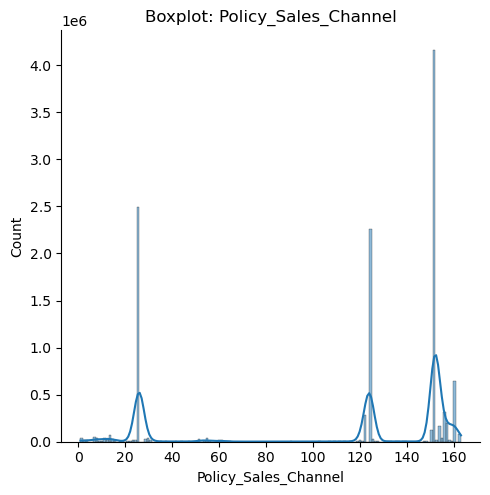

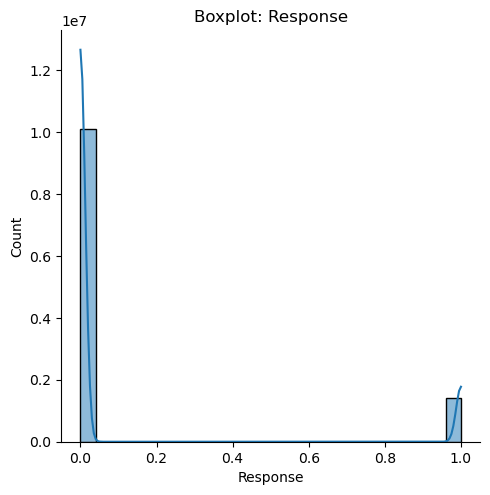

In [7]:
for col in df.columns:
    sns.displot(df[col], kde=True)
    plt.title(f'Boxplot: {col}')
    plt.show()

Можно видеть, что как таковых выбросов нет, по всем признакам данные сконцентрированны около определённых значений.

Если посмотреть на признак ```Policy_Sales_Channel```, то мы можем наблюдать три моды, около которых всё сосредоточено. Упростим данные, превратим этот признак в категориальный. Видим, что есть три явные моды, возьмём их как категории

In [8]:
from scipy.stats import gaussian_kde

In [ ]:
row_num = 5000000

data = df['Policy_Sales_Channel'][:row_num]

kde = gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 1000)

kde_derivative = np.gradient(kde(x))
mode_indices = np.where((kde_derivative[:-1] > 0) & (kde_derivative[1:] <= 0))[0]
modes = x[mode_indices]

density_values = kde(modes)

top_3_modes_indices = np.argsort(density_values)[-3:]
top_3_modes = modes[top_3_modes_indices]


In [10]:
t = np.sort(np.round(top_3_modes))
# Вывод:
print("Топ-3 моды (с наибольшей плотностью):", t)
s = ""
for pos in t:
    s += str(int(pos))
    s += " "
with open("channel_modes.txt", "w") as text_file:
    text_file.write(s)

Топ-3 моды (с наибольшей плотностью): [ 26. 124. 152.]


### Преобразуем ```Policy_Sales_Channel```

In [11]:
def encode(val, label_pos):
    dist = np.array(label_pos, copy=True)
    dist = np.abs(dist - val)
    return np.argmin(dist)

In [12]:
def load_policy_labels(path="channel_modes.txt"):
    with open(path, "r") as file:
        labels = file.readline().strip().split(" ")
        labels = [int(l) for l in labels]
    return labels

In [13]:
labels = load_policy_labels()
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].apply(lambda x: encode(x, labels))
print(df.head())

   Previously_Insured  Vehicle_Age  Vehicle_Damage  Policy_Sales_Channel  \
0                   0            1               1                     1   
1                   0            2               1                     0   
2                   1            0               0                     2   
3                   0            1               1                     2   
4                   1            1               0                     2   

   Response  
0         0  
1         1  
2         0  
3         0  
4         0  


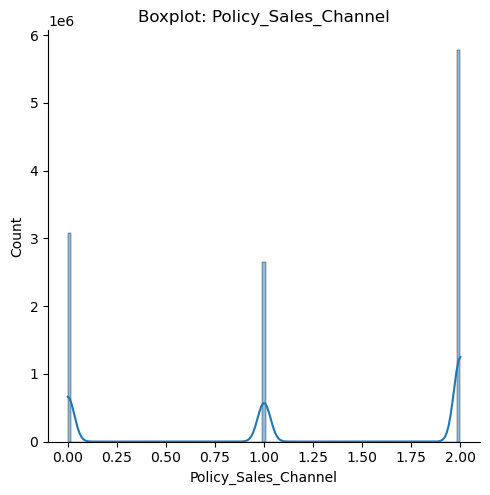

In [14]:
sns.displot(df["Policy_Sales_Channel"], kde=True)
plt.title(f'Boxplot: {"Policy_Sales_Channel"}')
plt.show()

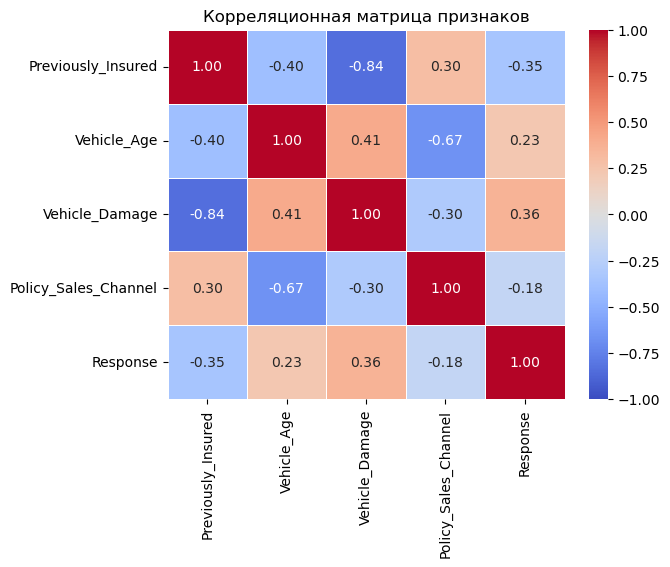

In [15]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1., vmax=1.)
plt.title('Корреляционная матрица признаков')
plt.show()

Видим, что ещё есть пары признаков, которые имеют какой-либо заметный эффект на ```Response```, при этом их взаимная корреляция достаточно велика. Проблема в том, что ```Vehicle_Age```, ```Vehicle_Damage``` и ```Previously_Insured``` это категориальные признаки и не получится трансформировать данные путём уменьшения размерности признаков, так как этот метод предназначен для непрерывных величин. Предлагается оставить эти признаки как есть

### Важность признаков

         Previously_Insured  Vehicle_Age  Vehicle_Damage  Policy_Sales_Channel
0                         0            1               1                     1
1                         0            2               1                     0
2                         1            0               0                     2
3                         0            1               1                     2
4                         1            1               0                     2
...                     ...          ...             ...                   ...
4999995                   0            1               0                     1
4999996                   1            0               0                     2
4999997                   1            1               0                     2
4999998                   0            1               1                     2
4999999                   1            0               0                     2

[5000000 rows x 4 columns]


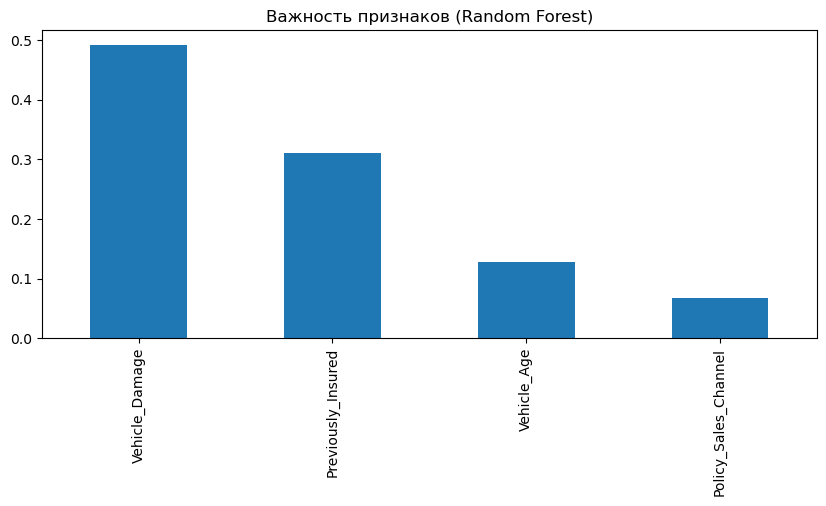

In [19]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop('Response', axis=1)[:row_num]
y = df['Response'][:row_num]
print(X)
model = RandomForestClassifier(random_state=0)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', figsize=(10, 4))
plt.title('Важность признаков (Random Forest)')
plt.show()

Последующая работа будет вестись с этими признаками, теперь сохраним два отдельных датасета:

* Первые 5 млн строк -- обучение

* Оставшиеся данные -- тест